# CS 412 Project
Alaa Almouradi    
Omar Mirza    
Saleh Alshurafa    
Abbas Ali Hakeem    
M. Safwan Yasin    

## The Plan:    
1. Extract features from the data to see what features perform better    
2. Train-test split with shuffled data    
3. Select models and perform hyper parameter tuning to get best results

### 1. Feature extraction:
1. Question Presence:
- vectorize the questions of the assignment after cleaning them
- for each conversation: 
    - get number of prompts
    - get average length of prompt
    - for each response from chatgpt:
        - clean it
        - vectorize it
        - measure similarity between response and questions
        - add the similarity to each question as a column in the row
2. Representative similarity (unused but implemented):
- sort the scores
- make a representative vector for each 20% segment in the ordered scores
- for each conversation:
    - clean it
    - vectorize it
    - measure similarity between response and the 5 representative vectors
    - add the similarity to each representative vector as a column in the row
3. Keyword count:
- for each conversation:
    - count selected keywords in prompts and responses and use the count for each keyword as a feature
4. Calculated features:
- features calculated from previous features
        

In [25]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial import distance
import spacy
spacynlp = spacy.load("en_core_web_lg")

In [26]:
import os
import re
import os
import tqdm
from glob import glob

import pandas as pd
import numpy as np

from collections import defaultdict
from bs4 import BeautifulSoup

import string
import matplotlib.pyplot as plt

#### Cleaning and vectorizing the questions

In [27]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
#####################
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80%\ and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]


In [28]:
questions = [ i.lower().translate(str.maketrans('','',string.punctuation+"\n")) for i in questions]


In [29]:
questionsVectorized = [spacynlp(question).vector for question in questions]

#### Getting the data from files

In [30]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

  2%|▏         | 2/127 [00:00<00:10, 12.20it/s]

100%|██████████| 127/127 [00:15<00:00,  8.35it/s]


In [31]:

code2responses = defaultdict(list)
for code , convos in code2convos.items():
    GPTresponses = []
    for conv in convos:
        if conv["role"] == "assistant":   
            GPTresponses.append(conv["text"])
    code2responses[code] = GPTresponses   



In [32]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]].dropna()
code2grade = dict()
for code, grade in scores.to_dict("tight")["data"]:
    code2grade[code] = grade
len(code2grade)

126

Keyword cleaning (unused): Remove certain filler words from consideration

In [33]:
# words_to_remove = ['certainly', 'course', 'great', 'sure']

# for code, responses in code2responses.items():
#     responses = [ i.lower().translate(str.maketrans('','',string.punctuation+"\n")) for i in responses]
#     cleaned_responses = []
#     for response in responses:
#         cleaned_response = ' '.join([word for word in response.lower().split() if word not in words_to_remove])
#         cleaned_responses.append(cleaned_response)
#     code2responses[code] = cleaned_responses

        
# code2responses

#### Question Presence and Representative vectors

In [34]:
# order the scores
scores.sort_values(by=["grade"], inplace=True, ascending=False)

In [35]:
#make a representative vector for each fifth
pentileVectors = []
for i in range (5):
    pentile = np.zeros((300,))
    for j in scores.iloc[i*(scores.shape[0]//5):(i+1)*(scores.shape[0]//5)]["code"]:
        try:
            responses = code2responses[j]
        except:
            continue
        responsesVector = np.zeros((300,))
        for response in responses:
            responseClean = response.lower().translate(str.maketrans('','',string.punctuation+"\n"))
        
            responsesVector += spacynlp(responseClean).vector/len(responses)
        pentile += responsesVector/((i+1)*(scores.shape[0]//5)-i*(scores.shape[0]//5)+1)
    pentileVectors.append(pentile)
  

In [36]:
FinalDataFrame = pd.DataFrame({i:[] for i in (["code","response count","avg. response length" ]+["top "+str(l)+" fifth similarity" for l in range(1,6)]+["Q"+str(k)+" presence" for k in range(1,10)]+[str(j) for j in range(300)]+["grade"])})


In [37]:
for code, responses in code2responses.items():
    studentRow = {i:[0] for i in (["code","response count","avg. response length" ]+["top "+str(l)+" fifth similarity" for l in range(1,6)]+["Q"+str(k)+" presence" for k in range(1,10)]+[str(j) for j in range(300)]+["grade"])}
    
    studentRow["code"][0] = code
    try:
        studentRow["grade"][0] = code2grade[code]
    except:
        continue
    studentRow["response count"][0] = len(responses)
    try:
        studentRow["avg. response length"][0] = sum([len(i) for i in responses])/len(responses)
    except:
        studentRow["avg. response length"][0] = 0
    studentVector = np.zeros((300,))
    for response in responses:
        # clean the response 
        responseClean = response.lower().translate(str.maketrans('','',string.punctuation+"\n"))

        responseVector = spacynlp(responseClean).vector
        
        studentVector += responseVector / len(responses)
        
        for i in range(300):
            studentRow[str(i)][0]+= responseVector[i]/len(responses)

        
        # measure similarity with questions 
        # (different versions are commented out to test performance of different similarity metrics and methods of recording similarity)
        similarity = []
        for question in range(9):
            #studentRow["Q"+str(question+1)+" presence"][0] = (1.0 - distance.cosine(responseVector, questionsVectorized[question])) / len(responses)
            studentRow["Q"+str(question+1)+" presence"][0] = (1.0 /(1+ distance.euclidean(responseVector, questionsVectorized[question]))) / len(responses)
            
            #similarity.append(1.0 - distance.cosine(responseVector, questionsVectorized[question]))
            #similarity.append(1.0 /(1+ distance.euclidean(responseVector, questionsVectorized[question])))
            
        #qnum = np.array(similarity).argmax()+1
        #studentRow["Q"+str(qnum)+" presence"][0] += np.array(similarity).max()/len(responses)
    
    # measure similarity with representative vectors
    # (different versions are commented out to test performance of different similarity metrics)
    for k in range(5):
        studentRow["top "+str(k+1)+" fifth similarity"][0] = (1.0 /(1+ distance.euclidean(studentVector, pentileVectors[k])))
        #studentRow["top "+str(k+1)+" fifth similarity"][0] = (1.0 - distance.cosine(studentVector, pentileVectors[k]))
    
    studentRowFrame = pd.DataFrame(studentRow)
    FinalDataFrame = pd.concat([FinalDataFrame, studentRowFrame])
    


FinalDataFrame

,code,response count,avg. response length,top 1 fifth similarity,top 2 fifth similarity,top 3 fifth similarity,top 4 fifth similarity,top 5 fifth similarity,Q1 presence,Q2 presence,...,291,292,293,294,295,296,297,298,299,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,2218.500000,0.228392,0.191977,0.222714,0.252982,0.236511,0.004812,0.004353,...,-0.127357,0.718181,0.408075,-0.466869,1.120409,0.290087,-2.362462,-2.166914,0.800465,48.0
0,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,1653.111111,0.241666,0.203096,0.199066,0.258552,0.228758,0.003945,0.003034,...,-0.026360,0.877823,0.268821,-0.697356,0.702574,-0.085298,-2.083180,-2.442652,0.730275,99.0
0,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1636.222222,0.214095,0.222064,0.195110,0.198025,0.204584,0.003501,0.002800,...,-0.377180,0.958535,0.182306,-0.683194,0.959546,0.093472,-1.553406,-2.531710,1.012053,90.0
0,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1749.900000,0.316619,0.253115,0.265028,0.346919,0.317167,0.003264,0.002975,...,-0.075040,0.877138,0.494181,-0.608385,0.767160,0.088354,-2.170721,-2.184763,0.783525,97.0
0,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1455.441860,0.322102,0.274355,0.251310,0.300782,0.290301,0.000797,0.000484,...,0.001565,0.906641,0.053110,-0.689573,0.772215,-0.106348,-1.679737,-2.382376,0.748501,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1818.285714,0.212467,0.176842,0.191438,0.228717,0.204544,0.003023,0.002873,...,0.032061,0.596367,0.431174,-0.806450,0.848590,-0.041885,-2.126962,-2.239128,0.682263,93.0
0,f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,1739.070423,0.248716,0.195947,0.207491,0.306865,0.243690,0.000783,0.000572,...,-0.157485,0.748673,0.277241,-0.695529,0.780302,0.153920,-2.096425,-2.357880,0.996960,100.0
0,f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,1420.266667,0.204193,0.172145,0.202812,0.227624,0.202849,0.002008,0.002017,...,0.103053,0.636822,0.604018,-0.674785,0.877443,0.221118,-2.351851,-2.056856,0.768765,98.0
0,f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,2214.571429,0.244148,0.191466,0.207582,0.297661,0.237849,0.004056,0.003825,...,-0.190045,0.671676,0.389282,-0.605829,0.874221,0.093926,-2.235041,-2.297529,0.914307,100.0


#### Keyword analysis

In [38]:
code2features = defaultdict(lambda : defaultdict(int))
keywords2search_p = [r'\bhypothetical\b', r'warning', r'error:', r'wrong', r'thank', r'\bentropy\b', r'\bno\b', r'\bpreprocess\b', r'hyperparameters', r're-train', r'\w?health_metrics\w?', r'how']
keywords2search_r = [r'thank', r'\bhypothetical\b', r'\bentropy\b', r'apologize', r'\bmissing\b', r'hyperparameters', r'\w?health_metrics\w?']

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search_p:
                code2features[code][f"#{kw}"] +=  len(re.findall(kw, text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses

            # count the keywords
            for kw in keywords2search_r:
                code2features[code][f"#{kw}"] +=  len(re.findall(kw, text))

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
df = pd.DataFrame(code2features).T
df.head(5)
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()
FinalDataFrame = pd.merge(df, FinalDataFrame, on="code", how="left")
FinalDataFrame.fillna(0, inplace=True)
FinalDataFrame

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


,code,#user_prompts,#\bhypothetical\b,#warning,#error:,#wrong,#thank,#\bentropy\b,#\bno\b,#\bpreprocess\b,...,291,292,293,294,295,296,297,298,299,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,13.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,...,-0.127357,0.718181,0.408075,-0.466869,1.120409,0.290087,-2.362462,-2.166914,0.800465,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,6.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,...,-0.026360,0.877823,0.268821,-0.697356,0.702574,-0.085298,-2.083180,-2.442652,0.730275,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,0.0,5.0,0.0,1.0,53.0,0.0,0.0,...,-0.377180,0.958535,0.182306,-0.683194,0.959546,0.093472,-1.553406,-2.531710,1.012053,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,3.0,0.0,2.0,0.0,0.0,34.0,1.0,0.0,...,-0.075040,0.877138,0.494181,-0.608385,0.767160,0.088354,-2.170721,-2.184763,0.783525,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,11.0,0.0,4.0,1.0,1.0,168.0,5.0,0.0,...,0.001565,0.906641,0.053110,-0.689573,0.772215,-0.106348,-1.679737,-2.382376,0.748501,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,0.0,0.0,0.0,0.0,1.0,81.0,0.0,0.0,...,0.032061,0.596367,0.431174,-0.806450,0.848590,-0.041885,-2.126962,-2.239128,0.682263,93.0
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,16.0,0.0,3.0,0.0,2.0,51.0,1.0,1.0,...,-0.157485,0.748673,0.277241,-0.695529,0.780302,0.153920,-2.096425,-2.357880,0.996960,100.0
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,68.0,0.0,6.0,0.0,0.0,48.0,1.0,0.0,...,0.103053,0.636822,0.604018,-0.674785,0.877443,0.221118,-2.351851,-2.056856,0.768765,98.0
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,14.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,...,-0.190045,0.671676,0.389282,-0.605829,0.874221,0.093926,-2.235041,-2.297529,0.914307,100.0


### 2. Train-test split

#### Calculated features are introduced into the dataframe here

In [39]:
shuffledFrame = shuffle(FinalDataFrame.drop(columns=[str(j) for j in range(300)]+["top "+str(k+1)+" fifth similarity" for k in range(5)]), random_state=42)

# Optimized feature selection:

# Combined chat stats
shuffledFrame['combined_chat_stats'] = shuffledFrame['prompt_avg_chars'] * shuffledFrame['#user_prompts'] + shuffledFrame['response count'] * shuffledFrame['avg. response length']
shuffledFrame['combined_chat_stats'].fillna(0, inplace=True)
# Combined questions
shuffledFrame['combined_questions'] = shuffledFrame['Q1 presence'] + shuffledFrame['Q2 presence'] + shuffledFrame['Q3 presence'] + shuffledFrame['Q4 presence'] + shuffledFrame['Q5 presence'] + shuffledFrame['Q6 presence'] + shuffledFrame['Q7 presence'] + shuffledFrame['Q8 presence'] + shuffledFrame['Q9 presence']
# Combined keywords feature
shuffledFrame['combined_kw'] = shuffledFrame['#user_prompts'] + shuffledFrame['#thank'] + shuffledFrame['#\w?health_metrics\w?'] + shuffledFrame['#re-train'] + shuffledFrame['#\\bpreprocess\\b'] + shuffledFrame['#\\bmissing\\b'] + shuffledFrame['#wrong'] + shuffledFrame['#\\bno\\b']

# Calculate the correlation matrix between the features and the target variable
corr_matrix = shuffledFrame.drop(columns=['code']).corr().abs()
# Print the correlations in decreasing order
print(corr_matrix['grade'].sort_values(ascending=False))

Xframe = shuffledFrame.drop(columns=['code','grade'])
Yframe = shuffledFrame['grade']
train_data, test_data, train_labels, test_labels = train_test_split(Xframe, Yframe, test_size=0.2, random_state=42)

grade                    1.000000
prompt_avg_chars         0.363722
Q5 presence              0.318202
Q3 presence              0.297784
combined_questions       0.285723
Q8 presence              0.283698
Q6 presence              0.277607
Q7 presence              0.276563
Q1 presence              0.273892
Q4 presence              0.269119
Q2 presence              0.262354
Q9 presence              0.259471
response count           0.225545
combined_chat_stats      0.224157
combined_kw              0.170818
#user_prompts            0.162624
#thank                   0.154763
#\w?health_metrics\w?    0.152238
#re-train                0.114495
#\bpreprocess\b          0.114228
#\bmissing\b             0.107345
#wrong                   0.106384
#\bno\b                  0.103511
#apologize               0.093068
#warning                 0.074610
#\bentropy\b             0.072700
#\bhypothetical\b        0.071749
#hyperparameters         0.060051
avg. response length     0.049112
#how          

In [17]:
test_data.shape[1]

30

### 3. Models

Five models were trained: 
- Decision Tree 
- K-NN
- Gradient Boosting
- Random Forest
- Neural Network.

For each model:

 1. Finding the best hyper parameter combination: 
 - Create, train, and test a model with different hyper parameter combination to obtain the best possible combination. The criteria for best combination was which combination results in the least Mean Squared Error (MSE) on test data.

 2. Use the hyper parameter combination obtained from Step 1:
 - Train and test a model with the hyper parameter combination obtained in step 1

#### Model 1: Decision Tree

##### Finding the right hyper parameter combination for Decision Tree

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

min_mse_train = 1000
min_mse_test = 1000
min_r2_train = 1000
min_r2_test = 1000

for rs in range(50):
    for md in range(1, 51):

        regressor = DecisionTreeRegressor(random_state=rs,criterion='squared_error', max_depth=md)
        regressor.fit(train_data, train_labels)

        y_train_pred = regressor.predict(train_data)
        y_test_pred = regressor.predict(test_data)

        mse_train = mean_squared_error(train_labels, y_train_pred)
        mse_test = mean_squared_error(test_labels, y_test_pred)
        r2_train = r2_score(train_labels, y_train_pred)
        r2_test = r2_score(test_labels, y_test_pred)

        if(mse_test < min_mse_test):
            best_rs = rs
            best_md = md
            min_mse_train = mse_train
            min_mse_test = mse_test
            min_r2_train = r2_train
            min_r2_test = r2_test

        

print("BEST md: ", best_md, " BEST rs: ", best_rs)
print("MSE Train:", mean_squared_error(train_labels,y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels,y_test_pred))
print("R2 Train:", r2_score(train_labels,y_train_pred))
print("R2 TEST:", r2_score(test_labels,y_test_pred))

BEST md:  10  BEST rs:  45
MSE Train: 0.0
MSE TEST: 28.92
R2 Train: 1.0
R2 TEST: -0.24965431415929196


##### Using the obtained hyper parameter combination on a Decision Tree

MSE Train: 0.1825396825396825
MSE TEST: 19.209660493827165
R2 Train: 0.9993082846265403
R2 TEST: 0.1699365453095979


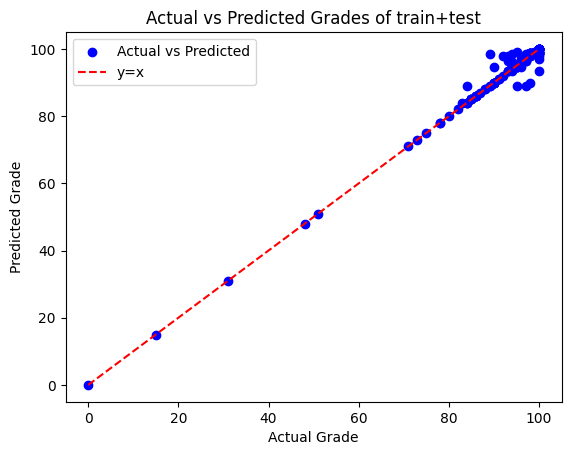

In [42]:
regressor = DecisionTreeRegressor(random_state=45,criterion='squared_error', max_depth=10)
regressor.fit(train_data, train_labels)

# Prediction
y_train_pred = regressor.predict(train_data)
y_test_pred = regressor.predict(test_data)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(train_labels,y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels,y_test_pred))

print("R2 Train:", r2_score(train_labels,y_train_pred))
print("R2 TEST:", r2_score(test_labels,y_test_pred))

actual_grades = np.concatenate([train_labels, test_labels])
predicted_grades = np.concatenate([y_train_pred, y_test_pred])

# Create scatter plot
plt.scatter(actual_grades, predicted_grades, color='blue', label='Actual vs Predicted')

# Add a diagonal line y=x
plt.plot([min(actual_grades), max(actual_grades)], [min(actual_grades), max(actual_grades)], color='red', linestyle='--', label='y=x')

# Set labels and title
plt.xlabel('Actual Grade')
plt.ylabel('Predicted Grade')
plt.title('Actual vs Predicted Grades of train+test')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### Model 2: K-NN

##### Finding the right hyper parameter combination for K-NN

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

min_mse_train = 1000
min_mse_test = 1000
min_r2_train = 1000
min_r2_test = 1000

for i in range(1, 99):

        regressor = KNeighborsRegressor(n_neighbors=i)
        regressor.fit(train_data, train_labels)

        y_train_pred = regressor.predict(train_data)
        y_test_pred = regressor.predict(test_data)

        mse_train = mean_squared_error(train_labels, y_train_pred)
        mse_test = mean_squared_error(test_labels, y_test_pred)
        r2_train = r2_score(train_labels, y_train_pred)
        r2_test = r2_score(test_labels, y_test_pred)

        if(mse_test < min_mse_test):
            best_n = i
            min_mse_train = mse_train
            min_mse_test = mse_test
            min_r2_train = r2_train
            min_r2_test = r2_test

        

print("BEST n_neighbors: ", best_n)
print("MSE Train:", mean_squared_error(train_labels,y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels,y_test_pred))
print("R2 Train:", r2_score(train_labels,y_train_pred))
print("R2 TEST:", r2_score(test_labels,y_test_pred))

BEST n_neighbors:  68
MSE Train: 263.8942107455227
MSE TEST: 51.245381091212
R2 Train: 0.0
R2 TEST: -1.2143503306144563


##### Using the obtained hyper parameter combination on a K-NN

MSE Train: 247.38216315938143
MSE TEST: 43.43967993079582
R2 Train: 0.06257070793441577
R2 TEST: -0.877060284620256


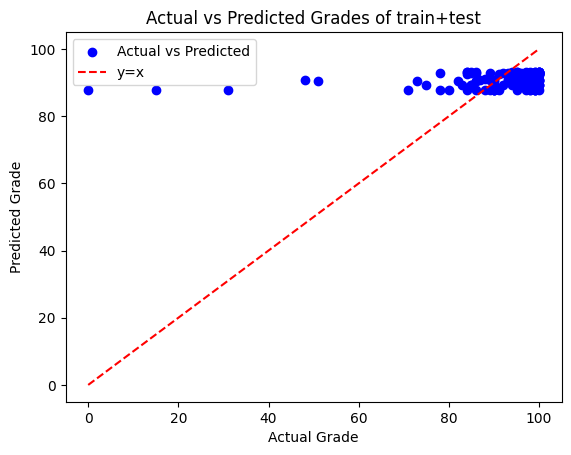

In [43]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=68)
regressor.fit(train_data, train_labels)

# Prediction
y_train_pred = regressor.predict(train_data)
y_test_pred = regressor.predict(test_data)

# Calculation of Mean Squared Error (MSE)accuracy_score, maccuracy_score, mean__
print("MSE Train:", mean_squared_error(train_labels,y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels,y_test_pred))

print("R2 Train:", r2_score(train_labels,y_train_pred))
print("R2 TEST:", r2_score(test_labels,y_test_pred))

actual_grades = np.concatenate([train_labels, test_labels])
predicted_grades = np.concatenate([y_train_pred, y_test_pred])

# Create scatter plot
plt.scatter(actual_grades, predicted_grades, color='blue', label='Actual vs Predicted')

# Add a diagonal line y=x
plt.plot([min(actual_grades), max(actual_grades)], [min(actual_grades), max(actual_grades)], color='red', linestyle='--', label='y=x')

# Set labels and title
plt.xlabel('Actual Grade')
plt.ylabel('Predicted Grade')
plt.title('Actual vs Predicted Grades of train+test')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### Model 3: Gradient Boosting

##### Findnig the right hyper parameter combination for Gradient Boosting

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

min_mse_train = 1000
min_mse_test = 1000
min_r2_train = 1000
min_r2_test = 1000

for rs in range(50):
    for md in range(1, 51):

        regressor = GradientBoostingRegressor(random_state=rs,criterion='squared_error', max_depth=md)
        regressor.fit(train_data, train_labels)

        y_train_pred = regressor.predict(train_data)
        y_test_pred = regressor.predict(test_data)

        mse_train = mean_squared_error(train_labels, y_train_pred)
        mse_test = mean_squared_error(test_labels, y_test_pred)
        r2_train = r2_score(train_labels, y_train_pred)
        r2_test = r2_score(test_labels, y_test_pred)

        if(mse_test < min_mse_test):
            best_rs = rs
            best_md = md
            min_mse_train = mse_train
            min_mse_test = mse_test
            min_r2_train = r2_train
            min_r2_test = r2_test

        

print("BEST md: ", best_md, " BEST rs: ", best_rs)
print("MSE Train:", mean_squared_error(train_labels,y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels,y_test_pred))
print("R2 Train:", r2_score(train_labels,y_train_pred))
print("R2 TEST:", r2_score(test_labels,y_test_pred))

BEST md:  9  BEST rs:  45
MSE Train: 1.8617945331384169e-07
MSE TEST: 22.29885565082347
R2 Train: 0.9999999992944921
R2 TEST: 0.03645016718994276


##### Using the obtained hyper parameter combination on a Gradient Boosting

MSE Train: 3.022744547818393e-07
MSE TEST: 18.453992948389082
R2 Train: 0.999999998854562
R2 TEST: 0.20258949165215878


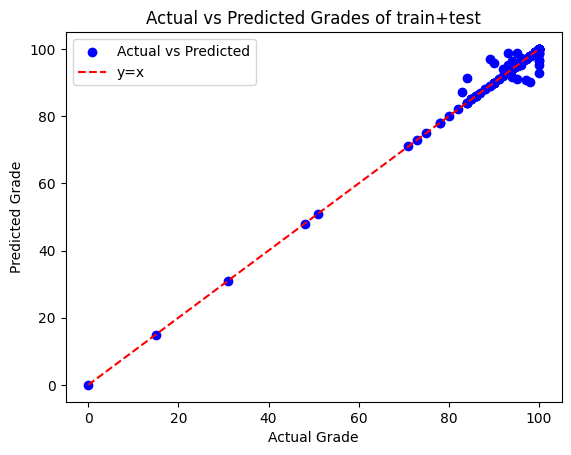

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(random_state=45,criterion='squared_error', max_depth=9)
regressor.fit(train_data, train_labels)

# Prediction
y_train_pred = regressor.predict(train_data)
y_test_pred = regressor.predict(test_data)

# Calculation of Mean Squared Error (MSE)accuracy_score, maccuracy_score, mean__
print("MSE Train:", mean_squared_error(train_labels,y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels,y_test_pred))

print("R2 Train:", r2_score(train_labels,y_train_pred))
print("R2 TEST:", r2_score(test_labels,y_test_pred))

actual_grades = np.concatenate([train_labels, test_labels])
predicted_grades = np.concatenate([y_train_pred, y_test_pred])

# Create scatter plot
plt.scatter(actual_grades, predicted_grades, color='blue', label='Actual vs Predicted')

# Add a diagonal line y=x
plt.plot([min(actual_grades), max(actual_grades)], [min(actual_grades), max(actual_grades)], color='red', linestyle='--', label='y=x')

# Set labels and title
plt.xlabel('Actual Grade')
plt.ylabel('Predicted Grade')
plt.title('Actual vs Predicted Grades of train+test')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### Model 4: Random Forest

##### Finding the right hyper parameter combination for Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

min_mse_train = 1000
min_mse_test = 1000
min_r2_train = 1000
min_r2_test = 1000

for rs in range(50):
    for md in range(1, 51):

        regressor = RandomForestRegressor(random_state=rs,criterion='squared_error', max_depth=md)
        regressor.fit(train_data, train_labels)

        y_train_pred = regressor.predict(train_data)
        y_test_pred = regressor.predict(test_data)

        mse_train = mean_squared_error(train_labels, y_train_pred)
        mse_test = mean_squared_error(test_labels, y_test_pred)
        r2_train = r2_score(train_labels, y_train_pred)
        r2_test = r2_score(test_labels, y_test_pred)

        if(mse_test < min_mse_test):
            best_rs = rs
            best_md = md
            min_mse_train = mse_train
            min_mse_test = mse_test
            min_r2_train = r2_train
            min_r2_test = r2_test

        

print("BEST md: ", best_md, " BEST rs: ", best_rs)
# Calculation of Mean Squared Error (MSE)accuracy_score, maccuracy_score, mean__
print("MSE Train:", mean_squared_error(train_labels,y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels,y_test_pred))
print("R2 Train:", r2_score(train_labels,y_train_pred))
print("R2 TEST:", r2_score(test_labels,y_test_pred))

BEST md:  1  BEST rs:  23
MSE Train: 43.70567346938775
MSE TEST: 68.14377999999999
R2 Train: 0.834381840564385
R2 TEST: -1.9445424847898227


##### Using the obtained hyper parameter combination on a Random Forest

MSE Train: 164.73069008961258
MSE TEST: 40.93075425389954
R2 Train: 0.3757699737927751
R2 TEST: -0.768647774383795


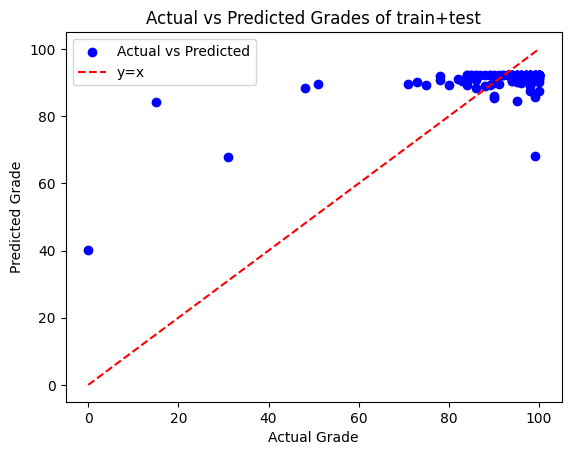

In [45]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state=23,criterion='squared_error', max_depth=1)
regressor.fit(train_data, train_labels)

# Prediction
y_train_pred = regressor.predict(train_data)
y_test_pred = regressor.predict(test_data)

# Calculation of Mean Squared Error (MSE)accuracy_score, maccuracy_score, mean__
print("MSE Train:", mean_squared_error(train_labels,y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels,y_test_pred))

print("R2 Train:", r2_score(train_labels,y_train_pred))
print("R2 TEST:", r2_score(test_labels,y_test_pred))

actual_grades = np.concatenate([train_labels, test_labels])
predicted_grades = np.concatenate([y_train_pred, y_test_pred])

# Create scatter plot
plt.scatter(actual_grades, predicted_grades, color='blue', label='Actual vs Predicted')

# Add a diagonal line y=x
plt.plot([min(actual_grades), max(actual_grades)], [min(actual_grades), max(actual_grades)], color='red', linestyle='--', label='y=x')

# Set labels and title
plt.xlabel('Actual Grade')
plt.ylabel('Predicted Grade')
plt.title('Actual vs Predicted Grades of train+test')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### Model 5: Neural Network

##### Finding the right hyper parameter combination for Neural Network

In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

min_mse_train = 1000
min_mse_test = 1000
min_r2_train = 1000
min_r2_test = 1000

for rs in range(50):
    for hls in range(1, 51):

        regressor = MLPRegressor(random_state=rs, activation="relu", hidden_layer_sizes=(hls,), max_iter=10000)
        regressor.fit(train_data, train_labels)

        y_train_pred = regressor.predict(train_data)
        y_test_pred = regressor.predict(test_data)

        mse_train = mean_squared_error(train_labels, y_train_pred)
        mse_test = mean_squared_error(test_labels, y_test_pred)
        r2_train = r2_score(train_labels, y_train_pred)
        r2_test = r2_score(test_labels, y_test_pred)

        if(mse_test < min_mse_test):
            best_rs = rs
            best_hls = hls
            min_mse_train = mse_train
            min_mse_test = mse_test
            min_r2_train = r2_train
            min_r2_test = r2_test      

print("BEST rs: ", best_rs, " BEST hls: ", best_hls)
# Calculation of Mean Squared Error (MSE)accuracy_score, maccuracy_score, mean__
print("MSE Train:", mean_squared_error(train_labels,y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels,y_test_pred))
print("R2 Train:", r2_score(train_labels,y_train_pred))
print("R2 TEST:", r2_score(test_labels,y_test_pred))

d:\CS412-PROJECT\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\CS412-PROJECT\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\CS412-PROJECT\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\CS412-PROJECT\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\CS412-PROJECT\venv\Lib\site-packages\sklearn\neural_network\_multilayer_p

BEST rs:  42  BEST hls:  10
MSE Train: 665582.2716780145
MSE TEST: 1106615.0521319904
R2 Train: -2521.155638798177
R2 TEST: -47816.64432954189


##### Using the obtained hyper parameter combination on a Neural Network

MSE Train: 467.13240036624126
MSE TEST: 181.36504430537153
R2 Train: -0.7701502395469537
R2 TEST: -6.8369159769674495


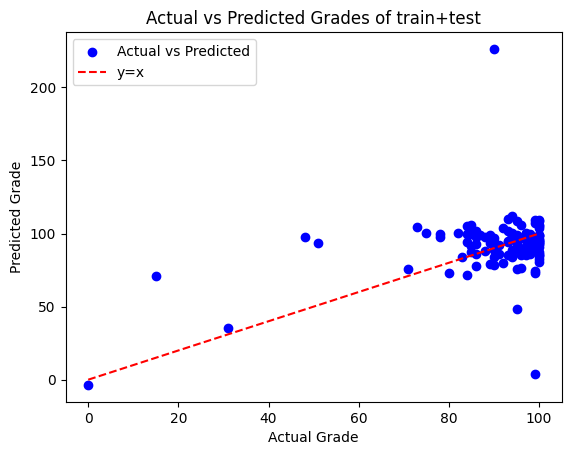

In [46]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create and train the MLPRegressor
regressor = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', max_iter=10000, random_state=42) #best so far 31, relu, 900, 35
regressor.fit(train_data, train_labels)

# Prediction
y_train_pred = regressor.predict(train_data)
y_test_pred = regressor.predict(test_data)

# Calculation of Mean Squared Error (MSE) and R2 Score
print("MSE Train:", mean_squared_error(train_labels, y_train_pred))
print("MSE TEST:", mean_squared_error(test_labels, y_test_pred))

print("R2 Train:", r2_score(train_labels, y_train_pred))
print("R2 TEST:", r2_score(test_labels, y_test_pred))

actual_grades = np.concatenate([train_labels, test_labels])
predicted_grades = np.concatenate([y_train_pred, y_test_pred])

# Create scatter plot
plt.scatter(actual_grades, predicted_grades, color='blue', label='Actual vs Predicted')

# Add a diagonal line y=x
plt.plot([min(actual_grades), max(actual_grades)], [min(actual_grades), max(actual_grades)], color='red', linestyle='--', label='y=x')

# Set labels and title
plt.xlabel('Actual Grade')
plt.ylabel('Predicted Grade')
plt.title('Actual vs Predicted Grades of train+test')

# Add legend
plt.legend()

# Show the plot
plt.show()